In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm
%install '.package(path: "$cwd/SwiftCV")' SwiftCV

Installing packages:
	.package(path: "/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
	.package(path: "/home/jmd/workspace/ml/fastai/nbs/swift/SwiftCV")
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmp6o7h42ig/swift-install
/home/jmd/swift/usr/bin/swift-build: /home/jmd/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jmd/swift/usr/lib/swift/linux/libFoundationNetworking.so)
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
import Path
import TensorFlow
#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif


In [3]:
import FastaiNotebook_07_batchnorm

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [5]:
public let dataPath = Path.home/".fastai"/"data"

In [6]:
public func downloadImagenette(path: Path = dataPath, sz:String="-320") -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette\(sz).tgz"
    let fname = "imagenette\(sz)"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

In [7]:
// export
enum ImageNette
{
  /// Downloads imagenette given the fastai data, and returns its "dataset root"
  static func download() -> Path { return downloadImagenette() }

  /// Extensions of paths which represent imagenette samples (i.e., items)
  static var extensions:[String] = ["jpeg", "jpg"]

  // Returns whether an image is in the training set (vs validation set), based on its path
  static func isTraining(_ p:Path) -> Bool {
    return p.parent.parent.basename() == "train"
  }

  /// Returns an image's label given the image's path
  static func labelOf(_ p:Path) -> String { return p.parent.basename() }
}

In [8]:
let path = ImageNette.download()

In [9]:
//export
public func collectFiles(under path: Path, recurse: Bool = false, filtering extensions: [String]? = nil) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += collectFiles(under: p.path, recurse: recurse, filtering: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased()) {
            res.append(p.path)
        }
    }
    return res
}

In [10]:
var allPaths = collectFiles(under: path, recurse: true, filtering: ImageNette.extensions)

In [11]:
(path.string, allPaths.randomElement()!.string)

▿ 2 elements
  - .0 : "/home/jmd/.fastai/data/imagenette-320"
  - .1 : "/home/jmd/.fastai/data/imagenette-320/train/n03888257/n03888257_18464.JPEG"


In [12]:
func describeSample(_ path:Path) 
{
    let isTraining = ImageNette.isTraining(path)
    let label = ImageNette.labelOf(path)
    print("""
          path: \(path.string)
          training?:  \(isTraining)
          label: \(label)
          """)
}


In [13]:
describeSample(allPaths.randomElement()!)

path: /home/jmd/.fastai/data/imagenette-320/train/n02102040/n02102040_1213.JPEG
training?:  true
label: n02102040


In [14]:
// export

/// takes a [T] of items, and returns a tuple (train:[T],val:[T]) items
func partitionIntoTrainVal<T>(_ items:[T],isTrain:((T)->Bool)) -> (train:[T],valid:[T]){
    return (train: items.filter(isTrain), valid: items.filter { !isTrain($0) })
}

In [15]:
var samples = partitionIntoTrainVal(allPaths, isTrain:ImageNette.isTraining)

In [16]:
describeSample(samples.valid.randomElement()!)

path: /home/jmd/.fastai/data/imagenette-320/val/n03394916/ILSVRC2012_val_00011691.JPEG
training?:  false
label: n03394916


In [17]:
describeSample(samples.train.randomElement()!)

path: /home/jmd/.fastai/data/imagenette-320/train/n03425413/n03425413_15291.JPEG
training?:  true
label: n03425413


In [18]:
// export
/// Defines bidirectional maps from String <-> Int32, initialized from a collection of Strings
public struct StringIntMapper {
  private(set) public var labelMap:[String]
  private(set) public var inverseLabelMap:[String:Int]
  public init<S:Sequence>(labels ls:S) where S.Element == String {
    labelMap = Array(Set(ls)).sorted()
    inverseLabelMap = Dictionary(uniqueKeysWithValues:
      labelMap.enumerated().map({ ($0.element, $0.offset) }))
  }
  public func labelToInt(_ label:String) -> Int { return inverseLabelMap[label]! }
  public func intToLabel(_ labelIndex:Int) -> String { return labelMap[labelIndex] }
}

In [19]:
var trainLabels = samples.train.map(ImageNette.labelOf)
var labelMapper = StringIntMapper(labels: trainLabels)

In [20]:
var randomLabel = labelMapper.labelMap.randomElement()!
print("label = \(randomLabel)")
var numericalizedLabel = labelMapper.labelToInt(randomLabel)
print("number = \(numericalizedLabel)")
var labelFromNumber = labelMapper.intToLabel(numericalizedLabel)
print("label = \(labelFromNumber)")

label = n03425413
number = 7
label = n03425413


In [21]:
// export
public func >| <A, B, C>(_ f: @escaping (A) -> B,
                   _ g: @escaping (B) -> C) -> (A) -> C {
    return { g(f($0)) }
}

In [22]:
var pathToNumericalizedLabel = ImageNette.labelOf >| labelMapper.labelToInt

In [23]:
var trainNumLabels = samples.train.map(pathToNumericalizedLabel)
var validNumLabels = samples.valid.map(pathToNumericalizedLabel)

In [24]:
struct SplitLabeledData {
    var mapper: StringIntMapper
    var train: [(x: Path, y: Int)]
    var valid: [(x: Path, y: Int)]
    
    init(mapper: StringIntMapper, train: [(x: Path, y: Int)], valid: [(x: Path, y: Int)]) {
        (self.mapper,self.train,self.valid) = (mapper,train,valid)
    }
}

In [25]:
extension SplitLabeledData {
    init(paths:[Path]){
        let samples = partitionIntoTrainVal(paths, isTrain:ImageNette.isTraining)
        let trainLabels = samples.train.map(ImageNette.labelOf)
        var labelMapper = StringIntMapper(labels:trainLabels)
        let pathToNumericalizedLabel = ImageNette.labelOf >| labelMapper.labelToInt
        self.init(mapper: labelMapper,
                  train:  samples.train.map { ($0, pathToNumericalizedLabel($0)) },
                  valid:  samples.valid.map { ($0, pathToNumericalizedLabel($0)) })
    }
}

In [26]:
let allPaths = collectFiles(under: path, recurse: true, filtering: ImageNette.extensions)
let sld = SplitLabeledData(paths: allPaths)

In [27]:
import Foundation
import SwiftCV

In [28]:
func openImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

In [29]:
func showCVImage(_ img: Mat) {
    let tensImg = Tensor<UInt8>(cvMat: img)!
    let numpyImg = tensImg.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

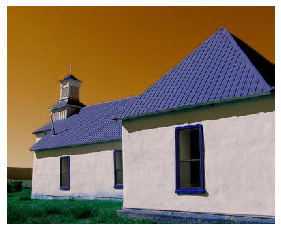

In [30]:
showCVImage(openImage(sld.train.randomElement()!.x))